In [1]:
#!pip install crepe
#!pip install tensorflow
#pip install numba==0.53

In [3]:
import fmplib as fmp
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import IPython.display as ipd
import crepe
import tensorflow

import sys
sys.path.append('/Users/ethancobb/Documents/Thesis/Code/Modules')
import midi_tools
import tuning_systems
import freq_detection
fmp.documentation_button()

In [2]:
file = "audio/test/maisky_scale.wav"

In [3]:
time, frequency, conf, act = freq_detection.load_file(file, 5)

NameError: name 'freq_detection' is not defined

In [1]:
plt.plot(frequency)

NameError: name 'plt' is not defined

<font color='red'> note: not counting a repeated instance of a note as a different note

In [7]:
actual_notes = ['C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3',
               'G2','E2', 'C2']

We want to obtain fundamental frequency estimates for each note in the audio. So far, we have converted the crepe frequency estimates to midi pitches and then to scientific pitch notation, and compared our estimates to the actual pitches to clean up the results. 

In order to the fundamentals for each note, we need to keep track of the crepe frequency estimate in this process.

In [8]:
freq_note_dict = freq_detection.calc_fundamental_freq(frequency, actual_notes, 440)
# print(freq_note_dict)
# print(len(freq_note_dict) == len(actual_notes))

In [9]:
f0_dict = freq_detection.calc_f0_with_simple_mean(freq_note_dict)
# print(f0_dict)

Let's check if our frequency approximations sound like the actual audio:

In [10]:
freq_detection.compare_audio(file, f0_dict)

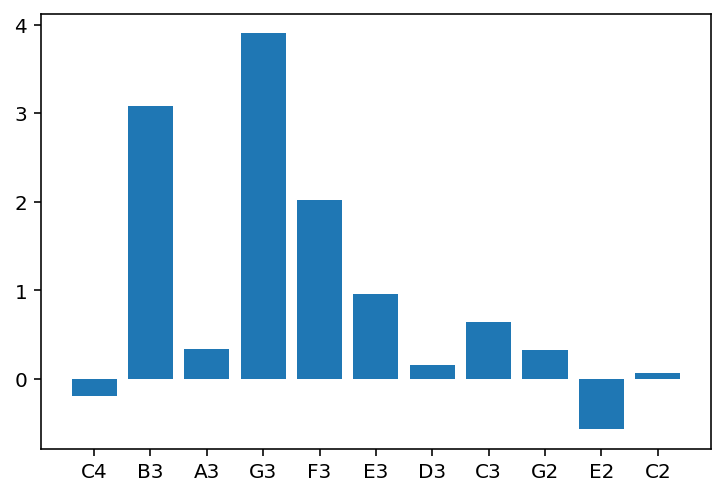

In [11]:
f0_estimates = sorted(list(f0_dict.values()))[::-1]
# print(f0_estimates)
freq_detection.calculate_and_plot_deviation_et(f0_estimates, actual_notes)

To think about the estimation of temperament, we need to be able to compute the musical interval between notes and calculate the corresponding frequeny ratio in different intonation systems. First, we tackle the problem of how to identify the musical interval between two notes. 

There are two ways of thinking of this task - one is by identifying the interval between two spn note names, and the other purely from the fundamental frequency values. 

## Calculating Interval between two notes in SPN 

<font color='red'> the fifth labeling for a tritone is 'minor fifth' in this intervals module, the handling of the octave difference is wrong - any note within an octave but with integer value less than another will be counted as an octave difference. This is because the mingus function was really made without the octave integer in the note string - maybe I'll need to experiment with music21? 

## Calculating Interval between two frequencies 

There are two ways of approaching this kind of problem - you can convert the frequencies to SPN values based on A440 and then determine the musical interval (normalized) or you can match the frequency ratio to the closest musical interval ratio in ET. 

In [12]:
pitch1 = 'F#'
pitch2 = 'C5'
print(freq_detection.identify_interval_spn(pitch1, pitch2))

d5


In [13]:
freq1 = 260.0
freq2 = freq1*2*2
print(freq_detection.identify_interval_freq1(freq1, freq2))

P8


In [14]:
print(freq_detection.match_ratio_to_inverval(1.3))

perfect fourth


In [15]:
freq1 = 260
freq2 = 260*1.25*2
print(freq_detection.identify_interval_freq2(freq1, freq2, freq_A4=440))

('major third', 1)


We need a function to sort our frequency dictionary according to the order of the actual notes

<font color='red'> is there a more optimal way to do this? 

In [16]:
sorted_note_dict = freq_detection.sort_note_dict(f0_dict, actual_notes)
sorted_note_dict

OrderedDict([('C4', 261.437694718383),
             ('B3', 250.02414656352101),
             ('A3', 220.3433088002261),
             ('G3', 199.8971792302986),
             ('F3', 176.63217731386007),
             ('E3', 165.77427190020487),
             ('D3', 146.98507626499105),
             ('C3', 131.45225101263944),
             ('G2', 98.32563917486165),
             ('E2', 81.84447782573307),
             ('C2', 65.47148298163026)])

We need a function to compute the intervals between each adjacent pair of notes in an array of notes, represented by frequencies or by SPN's. 

In [17]:
freq_detection.compute_pair_wise_intervals(sorted_note_dict)

['m2', 'M2', 'M2', 'M2', 'm2', 'M2', 'M2', 'P4', 'm3', 'M3']

## Determining Tuning System Labeling

Now we have the notes and their fundamental frequencies, to compute the labeling, we extract the reference pitch's fundamental frequency (C, through some kind of averaging process) and compare each of the values we got with that of the scale

<font color='red'> not sure best way to normalize to get mean reference frequency when there are multiple instances of same note

In [18]:
c_freq = np.array([sorted_note_dict['C4'], sorted_note_dict['C3'], sorted_note_dict['C2']])
print('original: ', c_freq)
c_freq[1] *= 2
c_freq[2] *= 2**2
c_freq_4 = np.mean(c_freq)
print("normalized to 4th octave: ", c_freq, 'mean = ', c_freq_4)

c_freq = np.array([sorted_note_dict['C4'], sorted_note_dict['C3'], sorted_note_dict['C2']])
print('\noriginal: ', c_freq)
c_freq[0] /= 2
c_freq[2] *= 2
c_freq_3 = np.mean(c_freq)
print("normalized to 3rd octave: ", c_freq, 'mean = ', c_freq_3)

c_freq = np.array([sorted_note_dict['C4'], sorted_note_dict['C3'], sorted_note_dict['C2']])
print('\noriginal: ', c_freq)
c_freq[0] /= 2**2
c_freq[1] /= 2
c_freq_2 = np.mean(c_freq)
print("normalized to 2nd octave: ", c_freq, 'mean = ', c_freq_2)

original:  [261.43769472 131.45225101  65.47148298]
normalized to 4th octave:  [261.43769472 262.90450203 261.88593193] mean =  262.07604289006093

original:  [261.43769472 131.45225101  65.47148298]
normalized to 3rd octave:  [130.71884736 131.45225101 130.94296596] mean =  131.03802144503047

original:  [261.43769472 131.45225101  65.47148298]
normalized to 2nd octave:  [65.35942368 65.72612551 65.47148298] mean =  65.51901072251523


In [19]:
# comparing these estimates if we normalize the means: 
c_freq_mean = np.array([c_freq_4, c_freq_3, c_freq_2])
c_freq_mean[1] *= 2
c_freq_mean[2] *= 2**2
c_freq_4_mean = np.mean(c_freq_mean)
print("normalized to 4th octave: ", c_freq, 'mean = ', c_freq_4_mean)

c_freq_mean = np.array([c_freq_4, c_freq_3, c_freq_2])
c_freq_mean[0] /= 2
c_freq_mean[2] *= 2
c_freq_3_mean = np.mean(c_freq_mean)
print("normalized to 3rd octave: ", c_freq, 'mean = ', c_freq_3_mean)

c_freq_mean = np.array([c_freq_4, c_freq_3, c_freq_2])
c_freq_mean[0] /= 2**2
c_freq_mean[1] /= 2
c_freq_2_mean = np.mean(c_freq_mean)
print("normalized to 2nd octave: ", c_freq, 'mean = ', c_freq_2_mean)

normalized to 4th octave:  [65.35942368 65.72612551 65.47148298] mean =  262.07604289006093
normalized to 3rd octave:  [65.35942368 65.72612551 65.47148298] mean =  131.03802144503047
normalized to 2nd octave:  [65.35942368 65.72612551 65.47148298] mean =  65.51901072251523


<font color='red'> it is evident that I will need functions to be able to produce the theoretical frequency values of a given note in SPN in a certain intonation system based on a reference pitch. For now, I know that the first 8 notes in the dictionary correspond to a descending C major scale, so I will extract that and work with it. I'll need a more general solution. 

In [20]:
sorted_note_dict_items = sorted_note_dict.items()
c_scale = list(sorted_note_dict_items)[:8]
print(c_scale)

[('C4', 261.437694718383), ('B3', 250.02414656352101), ('A3', 220.3433088002261), ('G3', 199.8971792302986), ('F3', 176.63217731386007), ('E3', 165.77427190020487), ('D3', 146.98507626499105), ('C3', 131.45225101263944)]


In [21]:
pitch = 'G3'
ref_pitch = ('C3', 131)

import Just
just = Just.Just()
just.calculate_just_frequency(pitch, ref_pitch)

P5


393/2

In [23]:
ref_pitch = c_freq_3_mean
cost = calculate_cost_scale(ref_pitch, 'just', c_scale)
print(cost)

NameError: name 'create_scale_template' is not defined

In [ ]:
c_scale_freq = np.array([c_scale[i][1] for i in range(len(c_scale))][::-1])
c_scale_freq